In [1]:
# Import relevant modules
import math
import numpy as np
import random as random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
import os
import glob
import warnings
import tarfile
warnings.filterwarnings("ignore")

mainDir = os.getcwd()
print(mainDir)

C:\Users\eilyness


In [2]:
# Load data from tar files
dataDir = mainDir + "/data/"
os.chdir(dataDir)

tarfiles = ['ngims_calibrated_2014.tar.gz', 'ngims_calibrated_2024.tar.gz', 
            'ngims_derivedL2_2014.tar.gz', 'ngims_derivedL2_2018.tar.gz', 'ngims_derivedL2_2024.tar.gz']
dataframes = [None] * 9

# Function to check if file contains data
def isValidFile(filename):
    isValidFile = False
    if not (filename.endswith('.csv')):
        return isValidFile
    validtypes = ['osion', 'osnb', 'ion-abund', 'csn-abund', 'raw-sci']
    for type in validtypes:
        if type in filename:
            isValidFile = True
    return isValidFile

for i in range(len(tarfiles)):
    print("Loading file {}".format(i+1))
    cur_tarfile = tarfiles[i]
    with tarfile.open(cur_tarfile, "r:*") as tar:
            if '2014' in cur_tarfile:
                csv_paths = list(n for n in tar.getnames() if (isValidFile(n) & ('2014/10' in n)))
            elif '2018' in cur_tarfile:
                csv_paths = list(n for n in tar.getnames() if (isValidFile(n) & ('2018/06' in n)))
            else:
                csv_paths = list(n for n in tar.getnames() if (isValidFile(n) & ('2024/01' in n)))
            for j in range(len(csv_paths)):
                path = csv_paths[j]
                data = pd.read_csv(tar.extractfile(path))
                dataframes[i] = pd.concat([dataframes[i], data], axis=0, ignore_index=True)
                print("{0:.2f}%".format(100 * (j+1) / len(csv_paths)), end='\r')

Loading file 1
Loading file 2
Loading file 3
Loading file 4
Loading file 5


In [3]:
# Load data from csv files (already unpacked)
dataDir1a_2014 = dataDir + "/NGIMSl1a_10-14/"
dataDir1a_2018 = dataDir + "/NGIMSl1a_06-18/"
dataDir1a_2024 = dataDir + "/NGIMSl1a_01-24/"
dataDir1b_2018 = dataDir + "/NGIMSl1b_06-18/"
dataDirs = [dataDir1a_2014, dataDir1a_2018, dataDir1a_2024, dataDir1b_2018]

for i in range(4):
    os.chdir(dataDirs[i])
    csv_files = list((n for n in os.listdir() if isValidFile(n)))
    for j in range(len(csv_files)):
        file = csv_files[j]
        data = pd.read_csv(file)
        dataframes[i+5] = pd.concat([dataframes[i+5], data], axis=0, ignore_index=True)
        print("{0:.2f}%".format(100 * (j+1) / len(csv_files)), end='\r')

In [4]:
# Clean up and organize data

# Create relevant data frames
L1a_df = pd.concat([dataframes[5], dataframes[6], dataframes[7]], axis=0, ignore_index=True)
L1b_df = pd.concat([dataframes[0], dataframes[7], dataframes[1]], axis=0, ignore_index=True)
L2_df = pd.concat([dataframes[2], dataframes[3], dataframes[4]], axis=0, ignore_index=True)

# Function to find year of data from spacecraft time
def find_year(t):
    if t < 5 * (10**8):
        return '2014'
    elif t > 7 * (10**8):
        return '2024'
    else:
        return '2018'

# Create joint time and mass variables for csn and osion data
L2_df["t_sclk_combined"] = L2_df["t_sclk"].fillna(0) + L2_df["t_sclk_cor"].fillna(0)
L2_df["mass_combined"] = L2_df["ion_mass"].fillna(0) + L2_df["mass"].fillna(0)

# Create year categorical variable for each dataframe
L1a_df["year"] = L1a_df["TIME"].apply(find_year)
L1b_df["year"] = L1b_df["t_sclk_cor"].apply(find_year)
L2_df["year"] = L2_df["t_sclk_combined"].apply(find_year)

# Convert dates to datetime type
L1b_df["t_utc"] = pd.to_datetime(L1b_df["t_utc"])
L2_df["t_utc"] = pd.to_datetime(L2_df["t_utc"])

# Create separate dataframes for csn and osion, remove variables that don't apply
L2_osion_df = L2_df[L2_df["focusmode"] == 'osion'].drop(["mass", "species", "cps_dt_bkd", 
                                                         "t_sclk_cor", "t_sclk_combined", "mass_combined"], axis=1)
L2_csn_df = L2_df[L2_df["focusmode"] == 'csn'].drop(["ion_mass", "cps_dt", "sensitivity", "SC_potential", 
                                                     "t_sclk", "t_sclk_combined", "mass_combined"], axis=1)

# Convert ram1 and ram2_rot_angle from level 1b to numbers
L1b_df = L1b_df.loc[pd.to_numeric(L1b_df["ram1"], errors='coerce').notna()]

L1a_df["MKID"] = L1a_df["MKID"].astype(int)
L1b_df["ram1"] = L1b_df["ram1"].astype(float)
L1b_df["ram2_rot_angle"] = L1b_df["ram2_rot_angle"].astype(float)


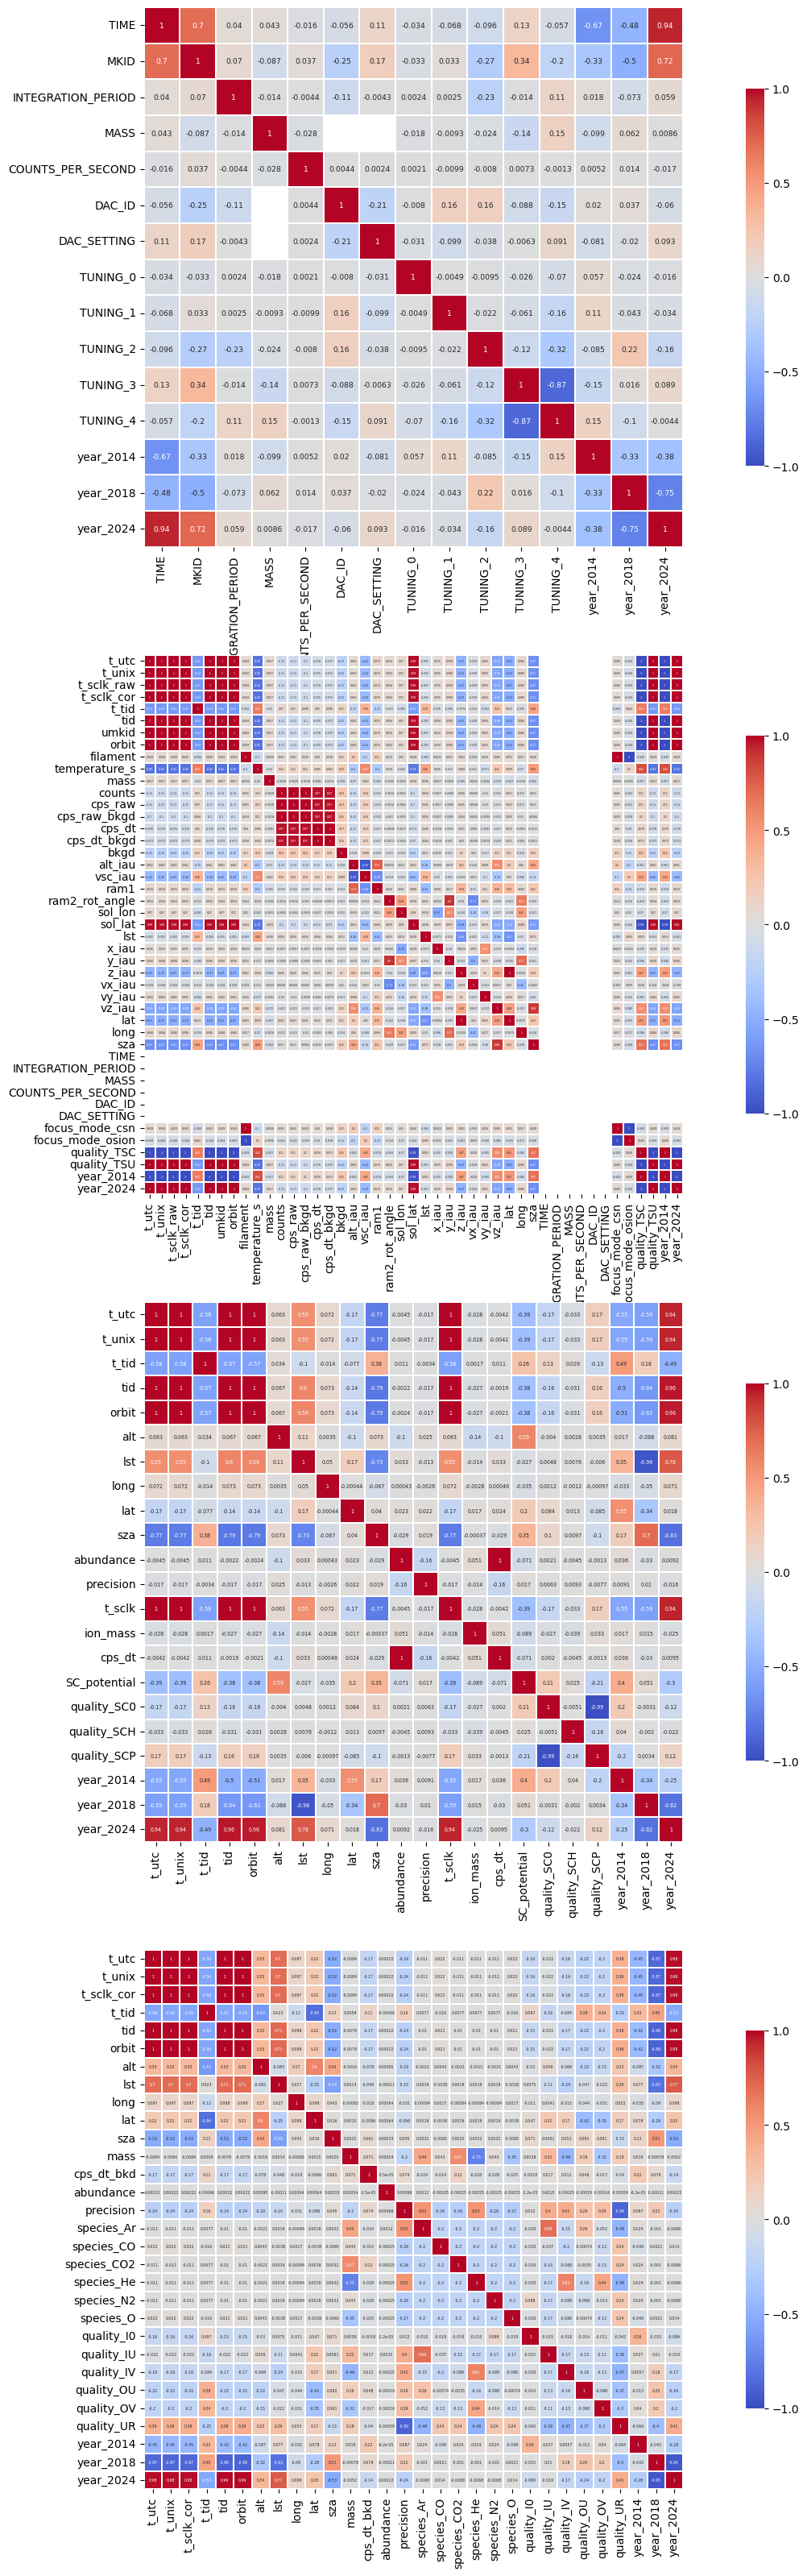

In [5]:
# Make heatmaps for each level of data

# Create filtered dataframes with dummies for categoricals and only interesting features
L1a_df_nums = pd.get_dummies(L1a_df)
L1b_df_nums = pd.get_dummies(L1b_df.drop("multiplier", axis=1))
L2_osion_df_nums = pd.get_dummies(L2_osion_df.drop(["focusmode", "sensitivity"], axis=1))
L2_csn_df_nums = pd.get_dummies(L2_csn_df.drop("focusmode", axis=1))

df_corrs = [L1a_df_nums, L1b_df_nums, L2_osion_df_nums, L2_csn_df_nums]

fig, axs = plt.subplots(4, 1, figsize=(20,40))

for i in range(4):
    sns.heatmap(df_corrs[i].corr(),
        ax = axs[i],
        square = True,
        linewidths = .3,
        cmap = 'coolwarm',
        cbar_kws = {'shrink': .7, 
                    'ticks' : [-1, -.5, 0, 0.5, 1]},
        vmin = -1, 
        vmax = 1,
        annot = True,
        annot_kws = {"size": 100 / len(df_corrs[i].columns)})

plt.savefig("NGIMS_heatmaps.png")

In [21]:
L1a_sample_data = L1a_df.iloc[range(0, len(L1a_df.index), 100)].sample(frac=1)
L1b_sample_data = L1b_df.iloc[range(0, len(L1b_df.index), 100)].sample(frac=1)
L2_sample_data = L2_df.iloc[range(0, len(L2_df.index), 100)].sample(frac=1)
L2_csn_sample_data = L2_sample_data[L2_sample_data["focusmode"] == 'csn']
L2_osion_sample_data = L2_sample_data[L2_sample_data["focusmode"] == 'osion']
L2_sample_data.info()
L2_sample_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 75679 entries, 5519200 to 6851500
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   t_utc            75679 non-null  datetime64[ns]
 1   t_unix           75679 non-null  float64       
 2   t_sclk_cor       44117 non-null  float64       
 3   t_tid            75679 non-null  float64       
 4   tid              75679 non-null  int64         
 5   orbit            75679 non-null  int64         
 6   focusmode        75679 non-null  object        
 7   alt              75679 non-null  float64       
 8   lst              75679 non-null  float64       
 9   long             75679 non-null  float64       
 10  lat              75679 non-null  float64       
 11  sza              75679 non-null  float64       
 12  mass             44117 non-null  float64       
 13  species          44117 non-null  object        
 14  cps_dt_bkd       44117 non-null  fl

,t_utc,t_unix,t_sclk_cor,t_tid,tid,orbit,focusmode,alt,lst,long,...,precision,quality,t_sclk,ion_mass,cps_dt,sensitivity,SC_potential,t_sclk_combined,mass_combined,year
5519200,2024-01-07 18:01:32,1.704650e+09,7.579222e+08,3688.217789,54216,20358,csn,628.5832,12.909170,124.96240,...,0.000000,IU,NaN,NaN,NaN,NaN,NaN,7.579222e+08,40.0,2024
3102200,2024-01-17 15:02:23,1.705504e+09,NaN,3961.758909,54346,20423,osion,417.5593,12.146670,-106.70280,...,0.051960,SCP,7.587754e+08,28.0,370.397465,550.0,-2.130517,7.587754e+08,28.0,2024
1556800,2018-06-18 21:11:30,1.529356e+09,5.826282e+08,5596.394389,27978,7239,csn,195.4281,7.170690,-110.86300,...,0.000256,OU,NaN,NaN,NaN,NaN,NaN,5.826282e+08,44.0,2018
5141400,2024-01-15 05:04:13,1.705295e+09,7.585667e+08,5230.421047,54314,20407,csn,457.3949,14.050280,48.15386,...,-999.000000,UR,NaN,NaN,NaN,NaN,NaN,7.585667e+08,44.0,2024
673700,2018-06-25 04:32:13,1.529901e+09,NaN,5906.464391,28046,7273,osion,354.6447,7.035556,-162.19750,...,0.003417,SCP,5.831730e+08,29.0,85629.715932,550.0,-1.307569,5.831730e+08,29.0,2018


<Figure size 2000x1000 with 0 Axes>

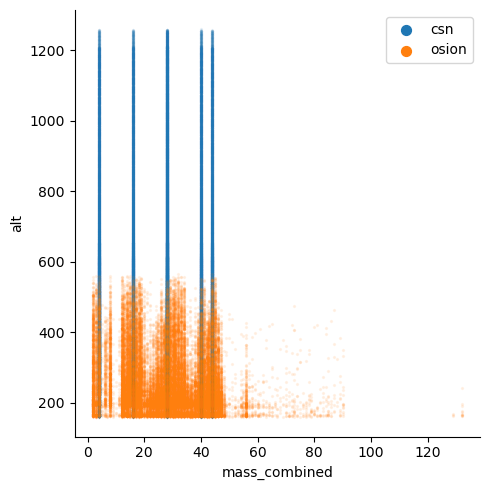

In [7]:
plt.figure(figsize=(20,10))
sns.lmplot(data=L2_sample_data, x="mass_combined", y="alt", hue="focusmode", scatter_kws={'alpha':0.08, 's':2}, fit_reg=False, legend=False)
leg = plt.legend(markerscale=5)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.savefig("Alt_vs_mass_csn_osion.png")

<Figure size 2000x1000 with 0 Axes>

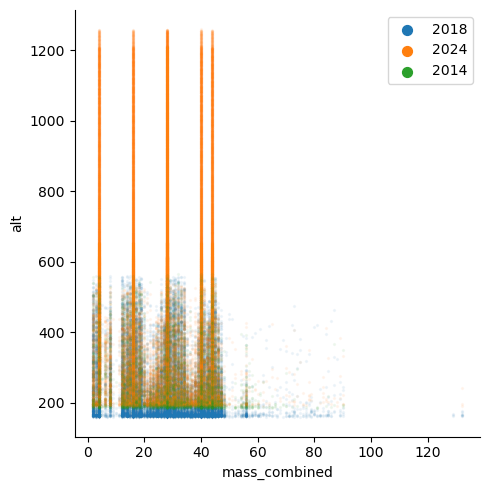

In [8]:
plt.figure(figsize=(20,10))
sns.lmplot(data=L2_sample_data, x="mass_combined", y="alt", hue="year", scatter_kws={'alpha':0.05, 's':2}, fit_reg=False, legend=False)
leg = plt.legend(markerscale=5)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

<Figure size 2000x1000 with 0 Axes>

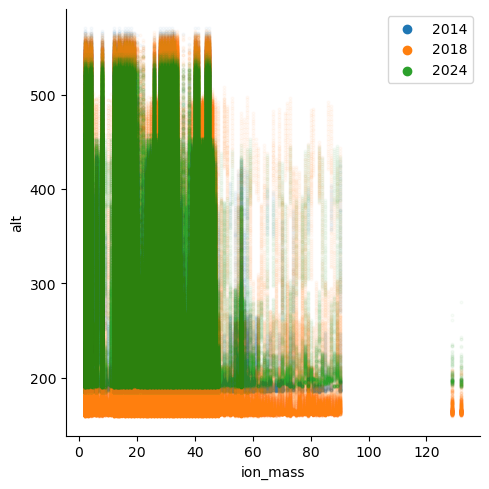

In [9]:
plt.figure(figsize=(20,10))
sns.lmplot(data=L2_osion_df, x="ion_mass", y="alt", hue="year", scatter_kws={'alpha':0.03, 's':4}, fit_reg=False, legend=False)
leg = plt.legend(markerscale=3)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

<Figure size 4000x4000 with 0 Axes>

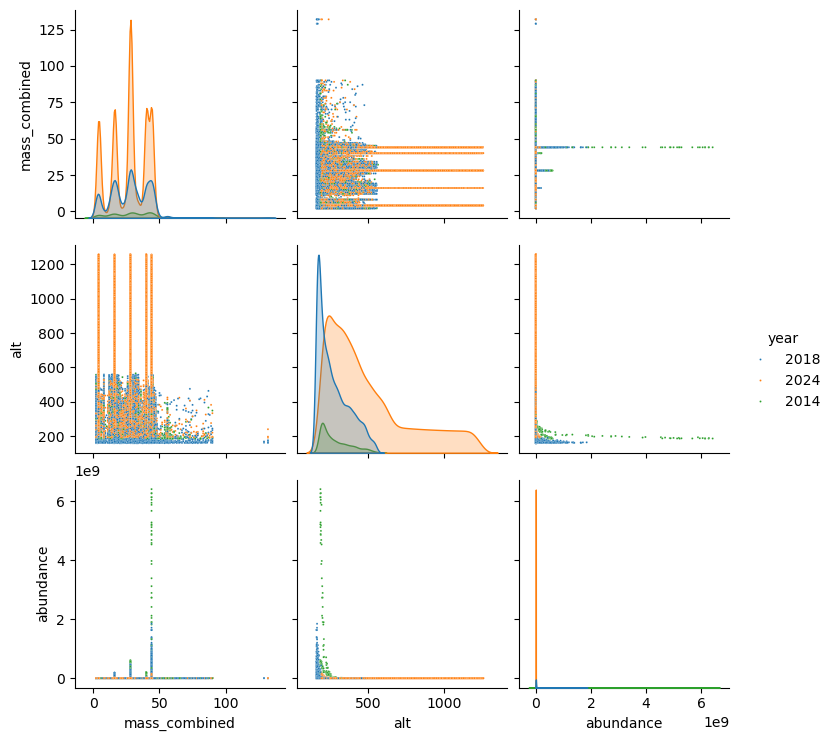

In [10]:
L2_sample_data = L2_sample_data[L2_sample_data["abundance"] < 10**10]
L2_csn_sample_data = L2_sample_data[L2_sample_data["focusmode"] == 'csn']
L2_osion_sample_data = L2_sample_data[L2_sample_data["focusmode"] == 'osion']
plt.figure(figsize=(40,40))
sns.pairplot(L2_sample_data, vars=["mass_combined", "alt", "abundance"], hue='year', diag_kind='kde', plot_kws={"s": 2})
plt.savefig("L2_pairplots.png")

<Figure size 3000x3000 with 0 Axes>

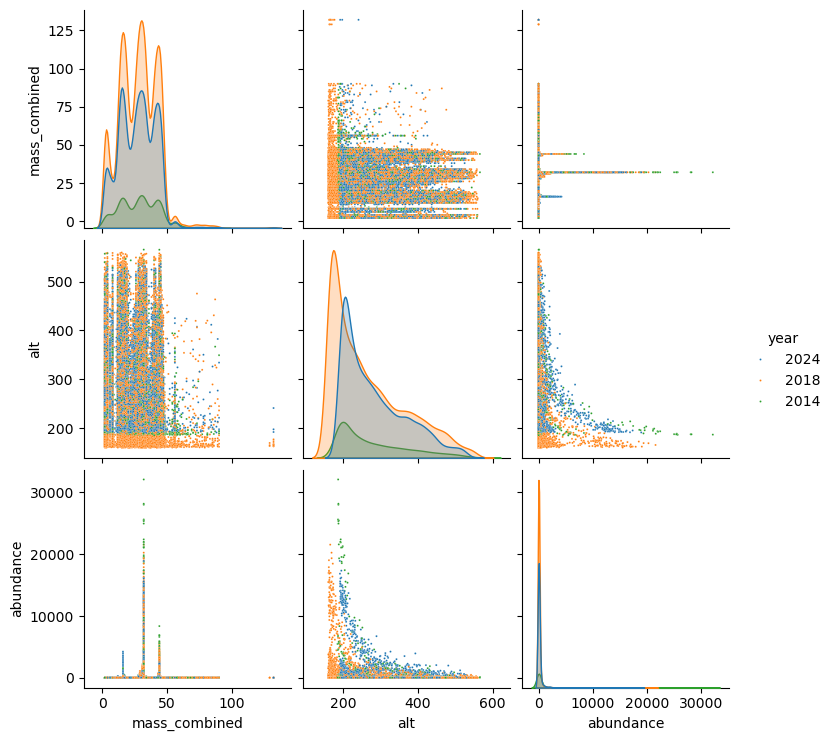

In [23]:
plt.figure(figsize=(30,30))
sns.pairplot(L2_osion_sample_data, vars=["mass_combined", "alt", "abundance"], hue='year', diag_kind='kde', plot_kws={"s": 2})
plt.savefig("L2_osion_pairplots.png")

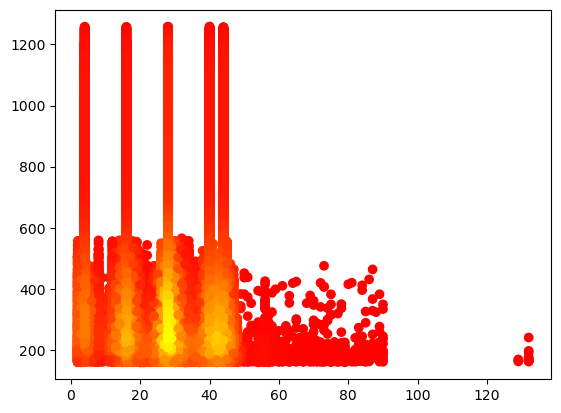

In [49]:
from scipy.stats import gaussian_kde as kde
from matplotlib.colors import Normalize
from matplotlib import cm

densObj = kde(L2_sample_data.loc[:,["mass_combined", "alt"]].transpose())

def makeColors(vals, colormap):
    colors = np.zeros((len(vals), 3))
    norm = Normalize(vmin=vals.min(), vmax=vals.max())

    #Can put any colormap you like here.
    colors = [cm.ScalarMappable(norm=norm, cmap=colormap).to_rgba(val) for val in vals]

    return colors, norm

colors = makeColors(densObj.evaluate(L2_sample_data.loc[:,["mass_combined", "alt"]].transpose()), 'autumn')[0]

plt.scatter(x="mass_combined", y="alt", data=L2_sample_data, color=colors)
plt.show()

In [ ]:
ion_mass_alt_2014 = L2_osion_sample_data[L2_osion_sample_data["year"] == '2014'].loc[:,["mass_combined", "alt"]].transpose()
ion_mass_alt_2018 = L2_osion_sample_data[L2_osion_sample_data["year"] == '2018'].loc[:,["mass_combined", "alt"]].transpose()
ion_mass_alt_2024 = L2_osion_sample_data[L2_osion_sample_data["year"] == '2024'].loc[:,["mass_combined", "alt"]].transpose()
data_years = [ion_mass_alt_2014, ion_mass_alt_2018, ion_mass_alt_2024]
cmaps = ['Blues', 'Greens', 'Oranges']
years = ['2014', '2018', '2024']
handles = [None] * 3

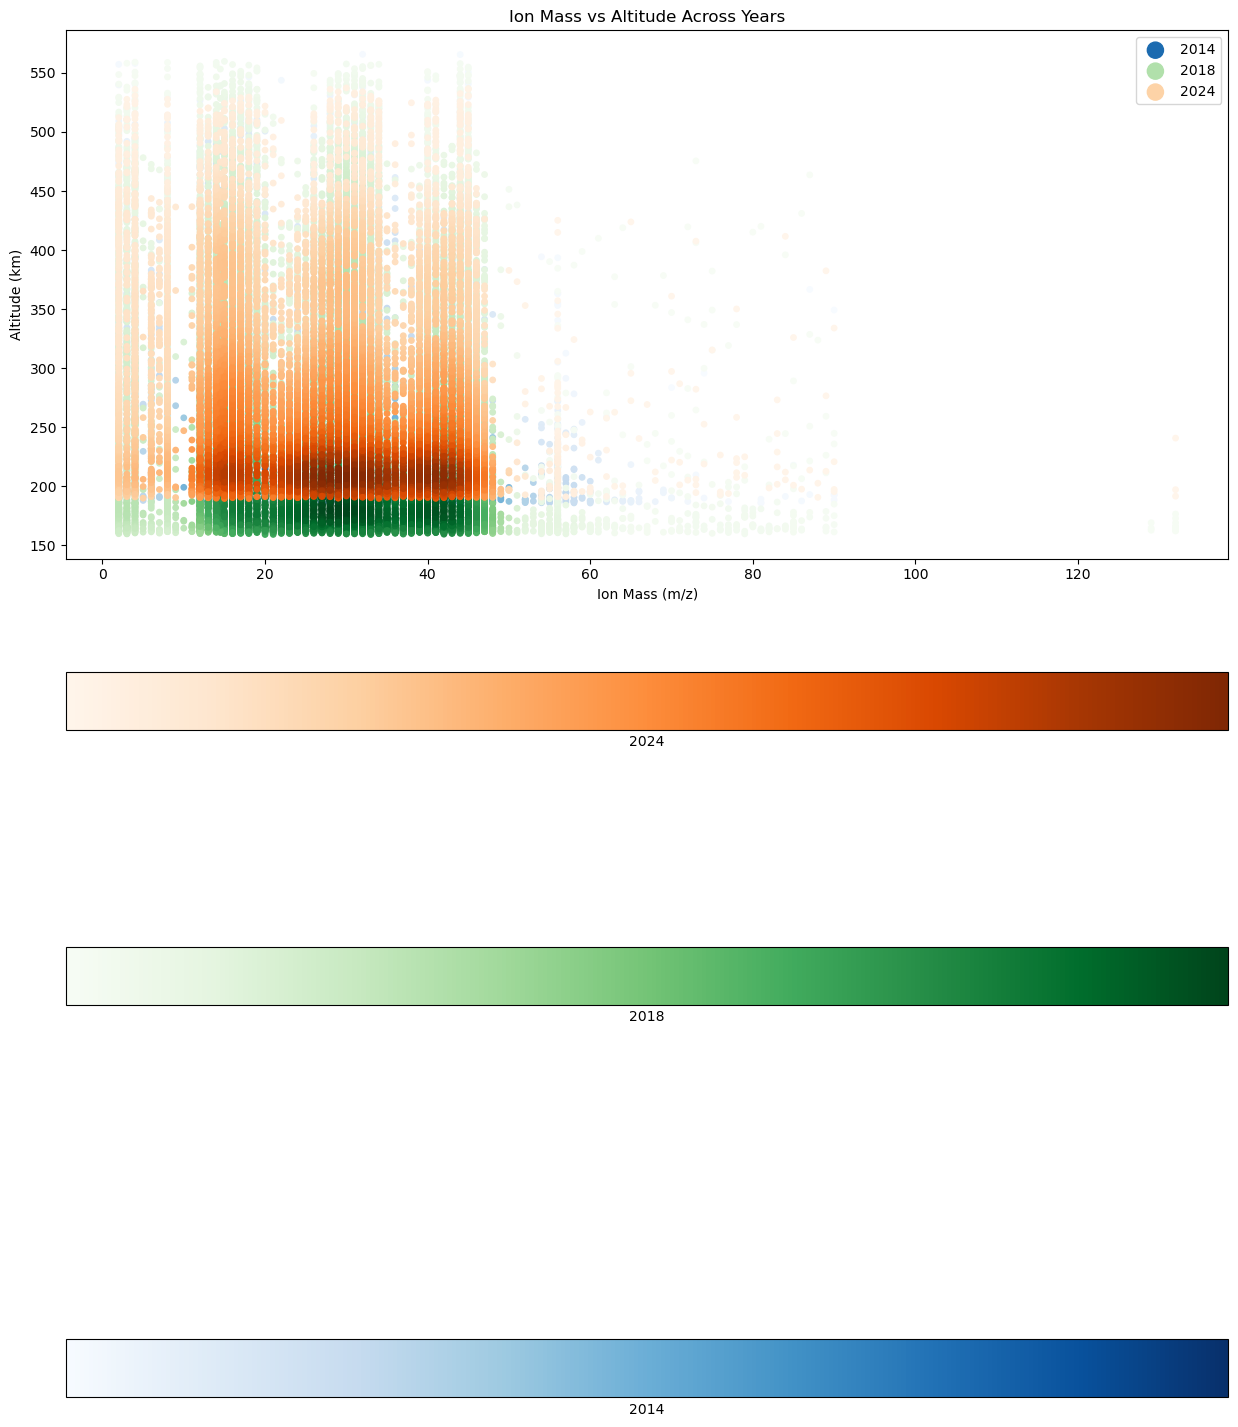

In [73]:
fig = plt.figure(figsize=(15,20))
for data, cmap, year, i in zip(data_years, cmaps, years, range(3)):
    densObj = kde(data)
    colors, norm = makeColors(densObj.evaluate(data), cmap)
    handles[i] = plt.scatter(x="mass_combined", 
                             y="alt", 
                             data=L2_osion_sample_data[L2_osion_sample_data["year"] == year], 
                             color=colors, 
                             alpha=1, 
                             s=15)
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(), location='bottom')
    cbar.set_ticks([])
    cbar.set_label(year)

plt.title("Ion Mass vs Altitude Across Years")
plt.xlabel("Ion Mass (m/z)")
plt.ylabel("Altitude (km)")
leg = plt.legend(handles, years, loc='upper right', markerscale=3)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.show()